<a href="https://colab.research.google.com/github/jethrocsau/GNN-language-embedded/blob/main/Sample_a_small_graph_for_mag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# First section: connect to drive and prepare the environment


In [ ]:
#Connect file to /content/drive, actually you colab folder path is /content/drive/MyDrive/colab
from google.colab import drive
drive.mount('/content/drive')

#Change the current path to our work directory
import os
path = "/content/drive/MyDrive/ColabNotebooks/socialScienceProject"
os.chdir(path)
os.listdir

!nvidia-smi
!pip install ogb
!pip install torch
!pip install dgl==1.1.0 -f https://data.dgl.ai/wheels/repo.html

Mounted at /content/drive
/bin/bash: line 1: nvidia-smi: command not found
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    

In [ ]:
from ogb.nodeproppred import DglNodePropPredDataset

mag_dataset = DglNodePropPredDataset(name = "ogbn-mag")
mag_split_idx = mag_dataset.get_idx_split()
mag_train_idx, mag_valid_idx, mag_test_idx = mag_split_idx["train"], mag_split_idx["valid"], mag_split_idx["test"]
mag_graph, mag_label = mag_dataset[0] # graph: dgl graph object, label: torch tensor of shape (num_nodes, num_tasks)

In [ ]:
from ogb.nodeproppred import DglNodePropPredDataset

arxiv_dataset = DglNodePropPredDataset(name = "ogbn-arxiv")
arxiv_split_idx = arxiv_dataset.get_idx_split()
arxiv_train_idx, arxiv_valid_idx, arxiv_test_idx = arxiv_split_idx["train"], arxiv_split_idx["valid"], arxiv_split_idx["test"]
arxiv_graph, arxiv_label = arxiv_dataset[0] # graph: dgl graph object, label: torch tensor of shape (num_nodes, num_tasks)

# Second Section: we need to output the basic information of this 2 dataset

In [ ]:

import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import random

# ------------------------- Utility Functions -------------------------
def plot_degree_distribution(degrees, title, filename, loglog=False):

    degree_counts = Counter(degrees)
    x, y = zip(*degree_counts.items())

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, s=20, alpha=0.6)
    plt.title(title, fontsize=14)
    plt.xlabel('Degree' if not loglog else 'Degree (log)')
    plt.ylabel('Frequency' if not loglog else 'Frequency (log)')

    if loglog:
        plt.xscale('log')
        plt.yscale('log')
        plt.grid(True, which="both", ls="--")
    else:
        plt.grid(True)

    plt.savefig(f"{filename}.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


def analyze_network(G, network_name):
    # ----------------- Basic Properties -----------------
    metrics = {
        'num_nodes': G.number_of_nodes(),
        'num_edges': G.number_of_edges(),
        'avg_in_degree': np.mean([d for _, d in G.in_degree()]),
        'avg_out_degree': np.mean([d for _, d in G.out_degree()]),
        'density': nx.density(G)
    }

    # ----------------- Degree Distributions -----------------
    print(G.number_of_nodes())
    print(G.number_of_edges())

    all_degrees = list(dict(G.degree()).values())
    print(all_degrees)

    plot_degree_distribution(all_degrees,
                           f"{network_name} Degree Distribution (Linear)",
                           f"{network_name}_degree_linear")
    plot_degree_distribution(all_degrees,
                           f"{network_name} Degree Distribution (Log-Log)",
                           f"{network_name}_degree_log",
                           loglog=True)


    # ----------------- Giant Component Analysis -----------------
    if nx.is_directed(G):
        scc = max(nx.strongly_connected_components(G), key=len)
        #gain the giant component, with all the attributes of the original graph
        G_gc = G.subgraph(scc)
    else:
        gcc = max(nx.connected_components(G), key=len)
        G_gc = G.subgraph(gcc)

    metrics['gc_nodes'] = G_gc.number_of_nodes()
    print(G_gc.number_of_nodes())

    # ----------------- Path Length Distribution -----------------
    path_lengths = []

    sample_size = 50
    sampled_nodes = random.sample(list(G_gc.nodes()), sample_size)

    for node in sampled_nodes:
        lengths = nx.single_source_shortest_path_length(G_gc, node)
        print
        path_lengths.extend(lengths.values())

    plt.figure(figsize=(10,6))
    plt.hist(path_lengths, bins=30)
    plt.title(f"{network_name} Path Length Distribution")
    plt.savefig(f"{network_name}_path_lengths.png", dpi=300)
    plt.show()
    plt.close()

    metrics['avg_path_length'] = np.mean(path_lengths)

    # ----------------- Clustering Analysis -----------------
    sampled_clustering = {}

    # Convert MultiDiGraph to DiGraph
    G_simple = nx.DiGraph(G_gc)
    for node in sampled_nodes:
        sampled_clustering[node] = nx.clustering(G_simple, node)
    clustering = sampled_clustering

    plt.figure(figsize=(10,6))
    plt.hist(clustering.values(), bins=30)
    plt.title(f"{network_name} Clustering Coefficients")
    plt.savefig(f"{network_name}_clustering.png", dpi=300)
    plt.show()
    plt.close()

    metrics['avg_clustering'] = np.mean(list(clustering.values()))

    return metrics


23164


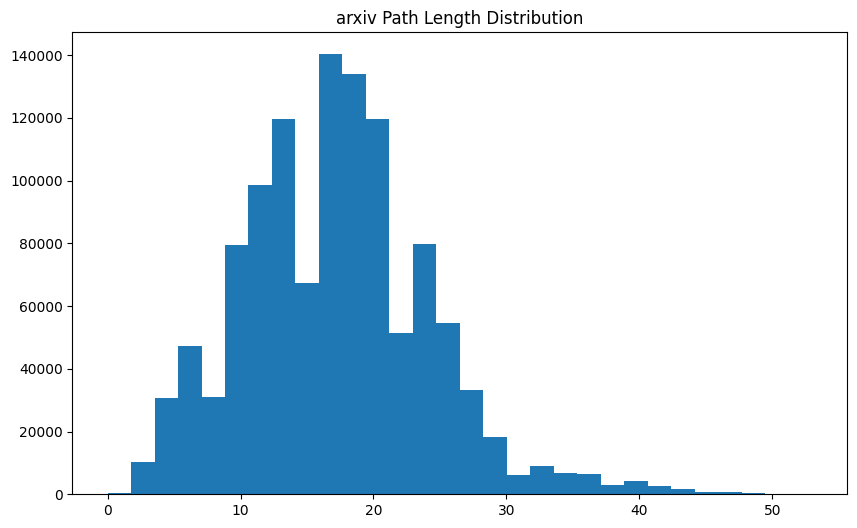

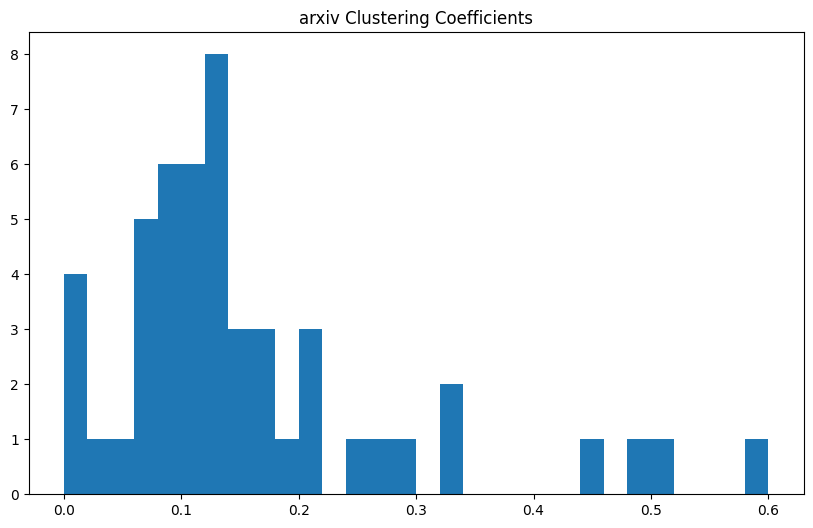

{'num_nodes': 169343, 'num_edges': 1166243, 'avg_in_degree': np.float64(6.886868663009395), 'avg_out_degree': np.float64(6.886868663009395), 'density': 4.066840277668502e-05, 'gc_nodes': 23164, 'avg_path_length': np.float64(17.13355724399931), 'avg_clustering': np.float64(0.1587980088051908)}


In [ ]:
import dgl
arxiv_G = dgl.to_networkx(arxiv_graph, edge_attrs=None, node_attrs=None)
arxiv_metrics = analyze_network(arxiv_G, "arxiv")
print(arxiv_metrics)

In [ ]:
import dgl
import networkx as nx
import matplotlib.pyplot as plt

# 使用广度优先搜索（BFS）提取子图，控制节点数量
def bfs_sampling_subgraph(graph, target_node_limit=20000):
    # 转换为 NetworkX 图
    homogeneous_graph = dgl.to_homogeneous(graph)
    nx_graph = dgl.to_networkx(homogeneous_graph)
    start_node = max(nx_graph.degree, key=lambda x: x[1])[0]

    # 使用 BFS 遍历节点并限制节点数
    visited_nodes = set()
    queue = [start_node]

    while queue and len(visited_nodes) < target_node_limit:
        node = queue.pop(0)
        if node not in visited_nodes:
            visited_nodes.add(node)
            queue.extend(nx_graph.neighbors(node))  # 添加邻居节点

    # 创建包含访问节点的子图
    subgraph = nx_graph.subgraph(visited_nodes).copy()
    return subgraph

# 使用示例
# 加载 MAG 数据集并提取 paper 节点和引用关系子图


# 仅保留 paper 节点和论文引用论文的关系
paper_edges = ('paper', 'cites', 'paper')
paper_graph = mag_graph.edge_type_subgraph([paper_edges])

# 随机选择一个起始节点（可以选择高度数节点提高连通性）

sampled_subgraph = bfs_sampling_subgraph(paper_graph,  target_node_limit=100000)

# 检查子图信息
print("Number of nodes in sampled subgraph:", sampled_subgraph.number_of_nodes())
print("Number of edges in sampled subgraph:", sampled_subgraph.number_of_edges())

Number of nodes in sampled subgraph: 100000
Number of edges in sampled subgraph: 1098063


100000
1098063
[7, 4, 19, 11, 13, 55, 23, 16, 1, 27, 27, 7, 9, 32, 28, 26, 3, 26, 8, 14, 3, 5, 3, 2, 3, 11, 36, 4, 3, 19, 14, 51, 3, 30, 37, 7, 4, 30, 4, 4, 8, 26, 15, 14, 1, 19, 6, 8, 17, 24, 2, 42, 24, 6, 44, 1, 24, 3, 42, 9, 35, 1, 66, 26, 8, 24, 55, 46, 1, 34, 40, 9, 2, 6, 12, 21, 7, 8, 6, 9, 24, 9, 17, 60, 11, 1, 39, 12, 8, 17, 19, 1, 17, 4, 53, 88, 67, 4, 7, 15, 15, 19, 33, 3, 7, 2, 5, 1, 6, 7, 6, 4, 78, 11, 1, 34, 4, 1, 12, 15, 1, 21, 1, 119, 26, 34, 1, 7, 2, 6, 8, 30, 18, 3, 11, 3, 50, 11, 5, 20, 47, 62, 8, 14, 9, 35, 1, 3, 26, 29, 39, 4, 6, 1, 1, 5, 13, 1, 1, 10, 23, 7, 4, 22, 36, 10, 5, 35, 31, 4, 9, 1, 24, 32, 32, 12, 20, 3, 44, 3, 19, 4, 48, 38, 24, 11, 7, 1, 4, 58, 26, 60, 4, 24, 4, 11, 4, 14, 13, 13, 16, 5, 7, 8, 28, 1, 30, 1, 2, 5, 15, 8, 11, 16, 10, 18, 11, 1, 1, 1, 8, 6, 4, 107, 29, 18, 3, 16, 19, 36, 1, 40, 1, 42, 3, 1, 4, 106, 1, 3, 4, 25, 5, 9, 8, 18, 14, 2, 6, 48, 4, 2, 1, 9, 1, 4, 5, 12, 11, 1, 4, 30, 5, 2, 6, 2, 17, 3, 2, 34, 21, 14, 14, 23, 23, 9, 13, 64, 12, 29

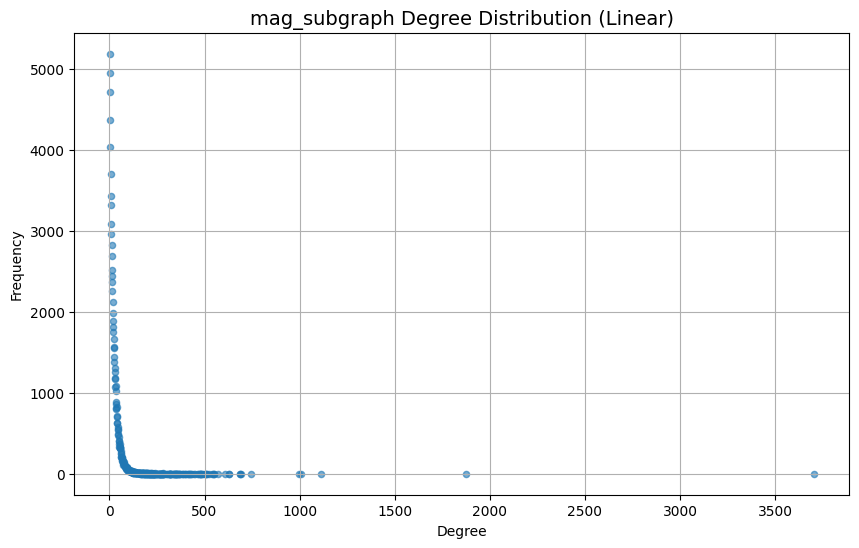

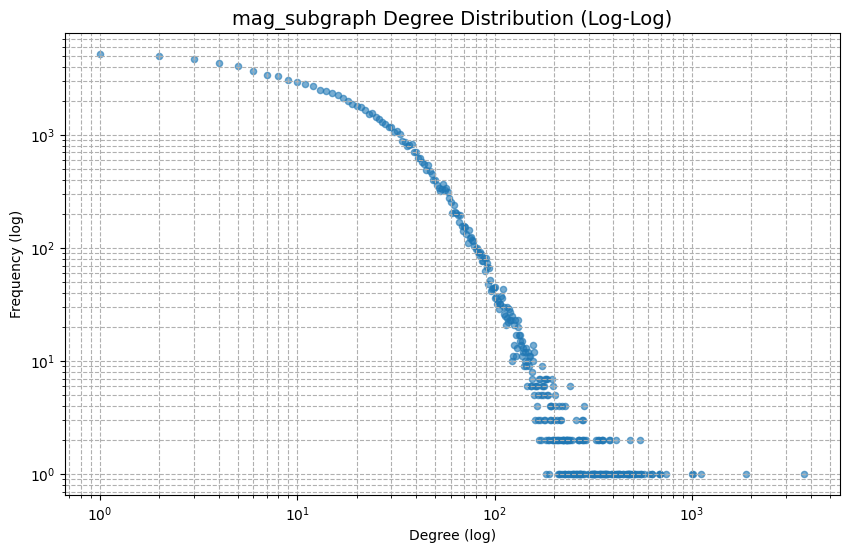

67153


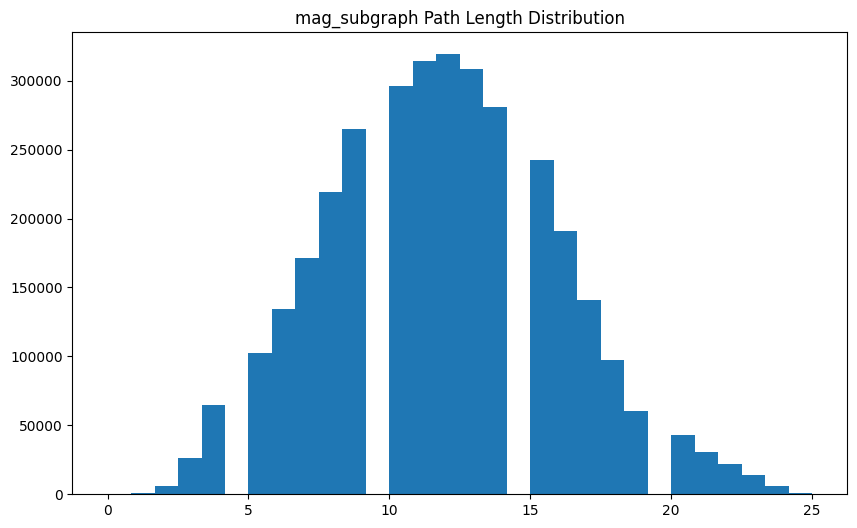

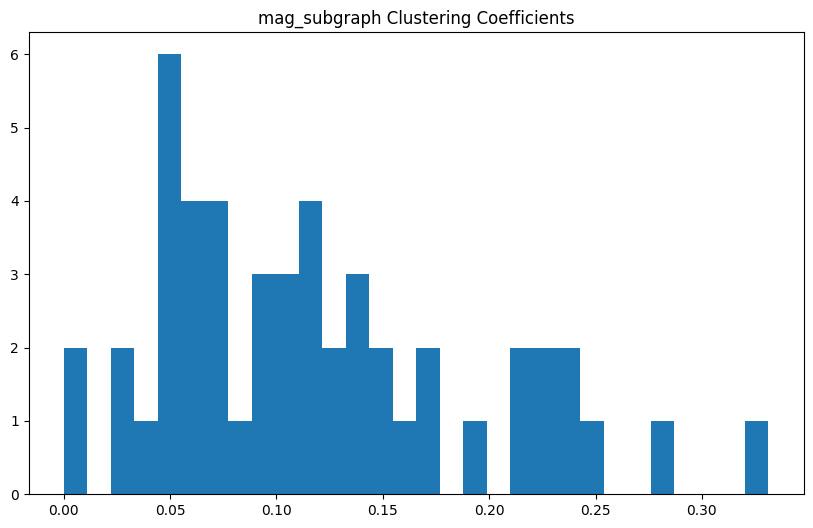

{'num_nodes': 100000, 'num_edges': 1098063, 'avg_in_degree': np.float64(10.98063), 'avg_out_degree': np.float64(10.98063), 'density': 0.00010980739807398073, 'gc_nodes': 67153, 'avg_path_length': np.float64(11.811792771730229), 'avg_clustering': np.float64(0.11881295273591638)}


In [ ]:
#mag_G = dgl.to_networkx(sampled_subgraph, edge_attrs=None, node_attrs=None)

mag_metrics = analyze_network(sampled_subgraph, "mag_subgraph")
print(mag_metrics)

# Third Section:we can train the graphsage using the original embedding of the 2 dataset individually

# Fourth Section:now we can train the graphsage using the 2 dataset together